In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import scFates as scf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize

In [2]:
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_pred = os.path.join(pth_data, 'modeling', 'predict')
pth_traj = os.path.join(pth_data, 'trajectories')
pth_out = os.path.join(pth, 'figures', 'modeling')

In [3]:
df = pd.read_csv(os.path.join(pth_data, 'summary.csv'), index_col = 0)
df

,Name,Study,Species,Trajectory,Age,Description
Source,,,,,,
GSE136689,Splanchnic Mesoderm,"Han et al., 2020",mmusculus,True,E8.5-9.5,Foregut organogenesis dataset showing interact...
GSE162534,Primitive Streak,"Scheibner et al., 2021",mmusculus,True,Early-Late Streak,Gastrulation dataset analyzing EMT programs du...
GSE201257,Schwann Cell Precursor,"Kastriti et al, 2022",mmusculus,True,E9.5-Adult,Neural crest cell atlas describing diversifica...
GSE229103,Neuromesodermal Progenitor,"Jin et al., 2025",mmusculus,True,E8.5,Developmental dataset describing bipotent neur...
HCAEmbryonicHindlimb,Embryonic Hindlimb,"Zhang et al., 2024",hsapiens,True,PCW5-9,Embryonic hindlimb atlas focusing on spatial a...
rRNAModifications,Cranial Neural Crest,Poverennaya et al.,mmusculus,True,E8.5-10.5,Neural crest cell dataset showing the bifurcat...
CCCA,Curated Cancer Cell Atlas,"Tyler et al., 2025",hsapiens,False,Primary & Metastatic,Cancer atlas containing 70+ curated single-cel...
EMTHallmark,EMT Hallmark,"Liberzon et al., 2015",hsapiens,False,NaN,Genes defining epithelial-mesenchymal transiti...
TCGA,The Cancer Genome Atlas,"TCGA Network, 2013",hsapiens,False,Primary & Metastatic,The Cancer Genome Atlas dataset of >40 cancer ...


In [4]:
adata = sc.read_h5ad(os.path.join(pth_pred, 'training.h5ad'))
adata

AnnData object with n_obs × n_vars = 1573925 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 'training', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score'

In [5]:
def z_to_u(z: np.ndarray, eps: float = 1e-6):
    s = np.maximum(np.expm1(z) - eps, 0.)
    return np.log(np.expm1(s))
adata.obs['latent_u'] = z_to_u(adata.obs.latent_z.values)

In [6]:
vmin, cmap = 0, 'inferno'

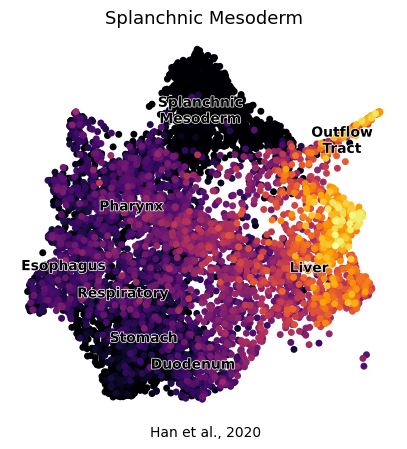

In [7]:
geo = 'GSE136689'
adata_plt = adata[adata.obs.source == geo].copy()
vmax = adata_plt.obs.latent_u.abs().max()

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sc.pl.embedding(adata_plt, 'X_draw_graph_fa', color = 'latent_u',
                size = 100, cmap = cmap, vmin = vmin, vmax = vmax,
                frameon = False, colorbar_loc = None, show = False,
                ax = ax)
sc.pl.embedding(adata_plt, 'X_draw_graph_fa', color = 'celltype',
                size = 100, alpha = 0, legend_loc = 'on data',
                na_in_legend = False, legend_fontoutline = 1,
                frameon = False, show = False, ax = ax)

label_dict = {
    'Splanchnic Mesoderm' : 'Splanchnic\nMesoderm',
    'Outflow Tract'       : 'Outflow\nTract'}

pos_dict = {
    'Splanchnic Mesoderm' : (0, 300),
    'Respiratory'         : (0, -300),
    'Outflow Tract'       : (5000, 800)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

ax.set_title(df.loc[geo].Name, size = 13)
ax.text(.36, -.05, df.loc[geo].Study, transform = ax.transAxes)
fn = os.path.join(pth_out, 'processed', f'{geo}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


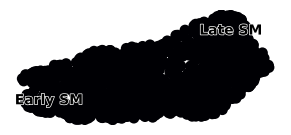

In [8]:
adata_traj = sc.read_h5ad(os.path.join(pth_traj, f'{geo}.h5ad'))
adata_traj.obs['latent_u'] = adata_plt[adata_traj.obs_names].obs.latent_u.copy()

fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, color = 'latent_u',
           cmap = cmap, vmin = vmin, vmax = vmax,
           size = 250, colorbar_loc = None,
           frameon = False, show = False, ax = ax)
scf.pl.milestones(adata_traj, basis = 'umap',
                  annotate = True, alpha = 0,
                  show = False, ax = ax)
ax.set_title('')
fn = os.path.join(pth_out, 'trajectories', f'{geo}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

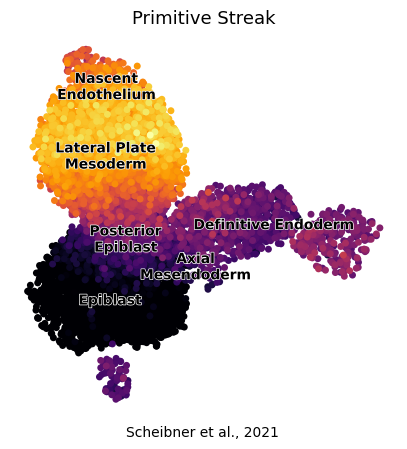

In [9]:
geo = 'GSE162534'
adata_plt = adata[adata.obs.source == geo].copy()
vmax = adata_plt.obs.latent_u.abs().max()

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sc.pl.umap(adata_plt, color = 'latent_u', size = 100,
           cmap = cmap, vmin = vmin, vmax = vmax,
           frameon = False, colorbar_loc = None,
           show = False, ax = ax)
sc.pl.umap(adata_plt, color = 'celltype', size = 100,
           alpha = 0, legend_loc = 'on data',
           na_in_legend = False, legend_fontoutline = 1,
           frameon = False, show = False, ax = ax)
ax.invert_yaxis()

label_dict = {
    'Nascent Endothelium'    : 'Nascent\nEndothelium',
    'Lateral Plate Mesoderm' : 'Lateral Plate\nMesoderm',
    'Posterior Epiblast'     : 'Posterior\nEpiblast',
    'Axial Mesendoderm'      : 'Axial\nMesendoderm'}

pos_dict = {
    'Axial Mesendoderm'      : (.1, .2),
    'Posterior Epiblast'     : (-.2, 0),
    'Definitive Endoderm'    : (.5, 0)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

ax.set_title(df.loc[geo].Name, size = 13)
ax.text(.3, -.05, df.loc[geo].Study, transform = ax.transAxes)
fn = os.path.join(pth_out, 'processed', f'{geo}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


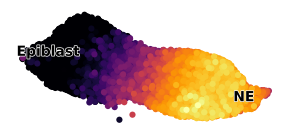

In [10]:
adata_traj = sc.read_h5ad(os.path.join(pth_traj, f'{geo}.h5ad'))
adata_traj = adata_traj[adata_traj.obs_names.isin(adata_plt.obs_names)].copy()
adata_traj.obs['latent_u'] = adata_plt[adata_traj.obs_names].obs.latent_u.copy()

fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, color = 'latent_u', size = 80,
           cmap = cmap, vmin = vmin, vmax = vmax,
           colorbar_loc = None, frameon = False,
           show = False, ax = ax)
scf.pl.milestones(adata_traj, basis = 'umap',
                  annotate = True, alpha = 0,
                  show = False, ax = ax)
ax.invert_xaxis(); ax.set_title('')

label_dict = {
    'Lateral Plate Mesoderm' : 'NE',
    'Posterior Epiblast'     : 'Epiblast'}

for label in ax.texts:
    _label_ = label.get_text()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])

fn = os.path.join(pth_out, 'trajectories', f'{geo}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

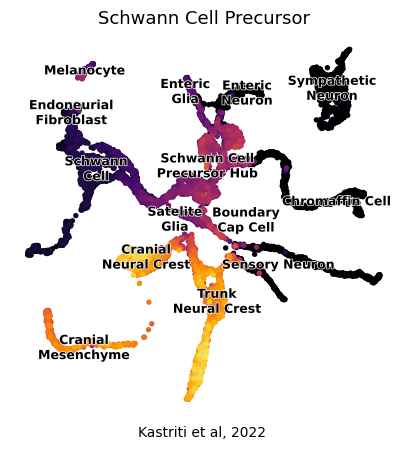

In [11]:
geo = 'GSE201257'
adata_plt = adata[adata.obs.source == geo].copy()
vmax = adata_plt.obs.latent_u.abs().max()

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sc.pl.umap(adata_plt, color = 'latent_u', size = 60,
           cmap = cmap, vmin = vmin, vmax = vmax,
           frameon = False, colorbar_loc = None,
           show = False, ax = ax)
sc.pl.umap(adata_plt, color = 'celltype', size = 60,
           alpha = 0, legend_fontsize = 9,
           legend_loc = 'on data', na_in_legend = False,
           legend_fontoutline = 1, frameon = False,
           show = False, ax = ax)

label_dict = {
    'Endoneurial Fibroblast'     : 'Endoneurial\nFibroblast',
    'Sympathetic Neuron'         : 'Sympathetic\nNeuron',
    'Enteric Neuron'             : 'Enteric\nNeuron',
    'Enteric Glia'               : 'Enteric\nGlia',
    'Schwann Cell'               : 'Schwann\nCell',
    'Schwann Cell Precursor Hub' : 'Schwann Cell\nPrecursor Hub',
    'Cranial Neural Crest'       : 'Cranial\nNeural Crest',
    'Trunk Neural Crest'         : 'Trunk\nNeural Crest',
    'Cranial Mesenchyme'         : 'Cranial\nMesenchyme',
    'Satelite Glia'              : 'Satelite\nGlia',
    'Boundary Cap Cell'          : 'Boundary\nCap Cell'}

pos_dict = {
    'Enteric Neuron'     : (1, 0),
    'Enteric Glia'       : (-.5, 0),
    'Schwann Cell'       : (.75, .75),
    'Trunk Neural Crest' : (1, .5),
    'Cranial Mesenchyme' : (1.75, -.5),
    'Satelite Glia'      : (-1.5, 0),
    'Boundary Cap Cell'  : (3, 0)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

ax.set_title(df.loc[geo].Name, size = 13)
ax.text(.33, -.05, df.loc[geo].Study, transform = ax.transAxes)
fn = os.path.join(pth_out, 'processed', f'{geo}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


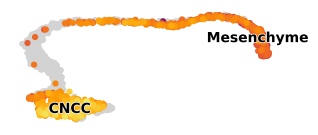

In [12]:
adata_traj = sc.read_h5ad(os.path.join(pth_traj, f'{geo}.h5ad'))
msk = adata_traj.obs_names.isin(adata_plt.obs_names)
ix = adata_traj.obs_names[msk]
adata_traj.obs.loc[ix, 'latent_u'] = adata_plt[ix].obs.latent_u.copy()

fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, color = 'latent_u', size = 80,
           cmap = cmap, vmin = vmin, vmax = vmax,
           colorbar_loc = None, frameon = False,
           show = False, ax = ax)
scf.pl.milestones(adata_traj, basis = 'umap',
                  annotate = True, alpha = 0,
                  show = False, ax = ax)
ax.invert_xaxis(); ax.invert_yaxis(); ax.set_title('')

label_dict = {'Neural Crest' : 'CNCC'}
pos_dict = {'Neural Crest' : (.6, 0)}
for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

fn = os.path.join(pth_out, 'trajectories', f'{geo}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

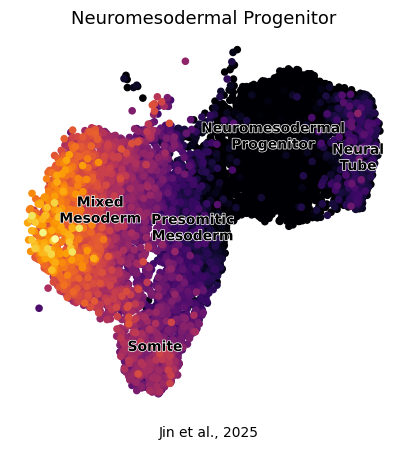

In [13]:
geo = 'GSE229103'
adata_plt = adata[adata.obs.source == geo].copy()
vmax = adata_plt.obs.latent_u.abs().max()

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sc.pl.umap(adata_plt, color = 'latent_u', size = 120,
           cmap = cmap, vmin = vmin, vmax = vmax,
           frameon = False, colorbar_loc = None,
           show = False, ax = ax)
sc.pl.umap(adata_plt, color = 'celltype', size = 120,
           alpha = 0, legend_loc = 'on data',
           na_in_legend = False, legend_fontoutline = 1,
           frameon = False, show = False, ax = ax)
ax.set_ylim(top = ax.get_ylim()[1] - 4)

label_dict = {
    'Neuromesodermal Progenitor' : 'Neuromesodermal\nProgenitor',
    'Neural Tube'                : 'Neural\nTube',
    'Presomitic Mesoderm'        : 'Presomitic\nMesoderm',
    'Mixed Mesoderm'             : 'Mixed\nMesoderm'}

pos_dict = {
    'Neuromesodermal Progenitor' : (-.25, .25),
    'Neural Tube'                : (.25, -.25)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

ax.set_title(df.loc[geo].Name, size = 13)
ax.text(.385, -.05, df.loc[geo].Study, transform = ax.transAxes)
fn = os.path.join(pth_out, 'processed', f'{geo}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

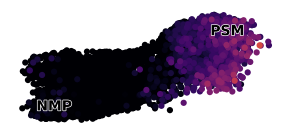

In [15]:
adata_traj = sc.read_h5ad(os.path.join(pth_traj, f'{geo}.h5ad'))
adata_traj = adata_traj[adata_traj.obs_names.isin(adata_plt.obs_names)].copy()
adata_traj.obs['latent_u'] = adata_plt[adata_traj.obs_names].obs.latent_u.copy()

fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, dimensions = [1, 0],
           color = 'latent_u', size = 80,
           cmap = cmap, vmin = vmin, vmax = vmax,
           colorbar_loc = None, frameon = False,
           show = False, ax = ax)
sc.pl.umap(adata_traj, dimensions = [1, 0],
           color = 'milestones', alpha = 0,
           legend_loc = 'on data', legend_fontoutline = 1,
           show = False, ax = ax)
ax.invert_xaxis(); ax.set_title('')

label_dict = {
    'Presomitic Mesoderm'        : 'PSM',
    'Neuromesodermal Progenitor' : 'NMP'}

pos_dict = {
    'Neuromesodermal Progenitor' : (1.5, -1.75),
    'Presomitic Mesoderm'        : (-1.33, 1.75)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

fn = os.path.join(pth_out, 'trajectories', f'{geo}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

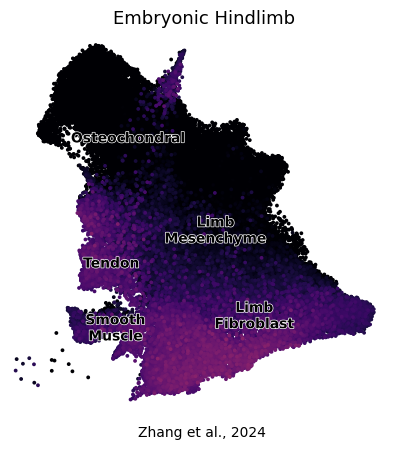

In [16]:
geo = 'HCAEmbryonicHindlimb'
adata_plt = adata[adata.obs.source == geo].copy()
vmax = adata_plt.obs.latent_u.abs().max()

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sc.pl.umap(adata_plt, color = 'latent_u', size = 30,
           cmap = cmap, vmin = vmin, vmax = vmax,
           frameon = False, colorbar_loc = None,
           show = False, ax = ax)
sc.pl.umap(adata_plt, color = 'celltype', size = 30,
           alpha = 0, legend_loc = 'on data',
           legend_fontoutline = 1, frameon = False,
           show = False, ax = ax)
ylim = ax.get_ylim()
ax.set_xlim(left = ax.get_xlim()[0] + 6)
ax.set_ylim(ylim[0] + 1, ylim[1] - 1.5)

label_dict = {
    'Limb Mesenchyme' : 'Limb\nMesenchyme',
    'Limb Fibroblast' : 'Limb\nFibroblast',
    'Smooth Muscle'   : 'Smooth\nMuscle'}

pos_dict = {
    'Limb Mesenchyme' : (.8, .2),
    'Limb Fibroblast' : (1, 0)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

ax.set_title(df.loc[geo].Name, size = 13)
ax.text(.33, -.05, df.loc[geo].Study, transform = ax.transAxes)
fn = os.path.join(pth_out, 'processed', f'{geo}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


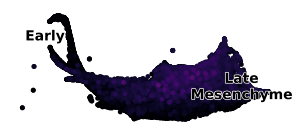

In [20]:
adata_traj = sc.read_h5ad(os.path.join(pth_traj, f'{geo}.h5ad'))
adata_traj.obs['latent_u'] = adata_plt[adata_traj.obs_names].obs.latent_u.copy()

fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.draw_graph(adata_traj, color = 'latent_u',
                 cmap = cmap, vmin = vmin, vmax = vmax,
                 size = 50, colorbar_loc = None,
                 frameon = False, show = False, ax = ax)
scf.pl.milestones(adata_traj, basis = 'draw_graph_fa',
                  annotate = True, alpha = 0,
                  show = False, ax = ax)
ax.invert_xaxis(); ax.invert_yaxis(); ax.set_title('')
ax.set_ylim(top = ax.get_ylim()[1] + 5)

label_dict = {
    'Early Mesenchyme' : 'Early',
    'Late Mesenchyme'  : 'Late\nMesenchyme'}

pos_dict = {
    'Early Mesenchyme' : (5, 6)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

fn = os.path.join(pth_out, 'trajectories', f'{geo}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

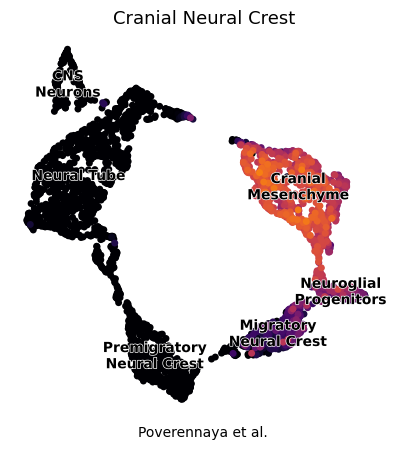

In [21]:
geo = 'rRNAModifications'
adata_plt = adata[adata.obs.source == geo].copy()
vmax = adata_plt.obs.latent_u.abs().max()

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sc.pl.umap(adata_plt, color = 'latent_u', size = 100,
           cmap = cmap, vmin = vmin, vmax = vmax,
           frameon = False, colorbar_loc = None,
           show = False, ax = ax)
sc.pl.umap(adata_plt, color = 'celltype', size = 100,
           alpha = 0, legend_loc = 'on data',
           legend_fontoutline = 1, frameon = False,
           show = False, ax = ax)
ax.set_xlim(right = ax.get_xlim()[1] + 1)

label_dict = {
    'CNS Neurons'               : 'CNS\nNeurons',
    'Premigratory Neural Crest' : 'Premigratory\nNeural Crest',
    'Migratory Neural Crest'    : 'Migratory\nNeural Crest',
    'Neuroglial Progenitors'    : 'Neuroglial\nProgenitors',
    'Cranial Mesenchyme'        : 'Cranial\nMesenchyme'}

pos_dict = {
    'CNS Neurons'               : (.15, 0),
    'Neural Tube'               : (-1, 0),
    'Premigratory Neural Crest' : (.15, .5)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

ax.set_title(df.loc[geo].Name, size = 13)
ax.text(.33, -.05, df.loc[geo].Study, transform = ax.transAxes)
fn = os.path.join(pth_out, 'processed', f'{geo}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


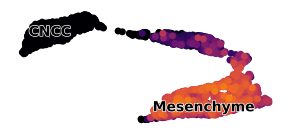

In [25]:
adata_traj = sc.read_h5ad(os.path.join(pth_traj, f'{geo}.h5ad'))
adata_traj = adata_traj[adata_traj.obs_names.isin(adata_plt.obs_names)].copy()
adata_traj.obs['latent_u'] = adata_plt[adata_traj.obs_names].obs.latent_u.copy()

fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, color = 'latent_u',
           cmap = cmap, vmin = vmin, vmax = vmax,
           size = 100, colorbar_loc = None,
           frameon = False, show = False, ax = ax)
scf.pl.milestones(adata_traj, basis = 'umap',
                  annotate = True, alpha = 0,
                  show = False, ax = ax)
ax.invert_yaxis(); ax.set_title('')

label_dict = {
    'migr_ncc'   : '',
    'mes_fork'   : '',
    'mes2'       : '',
    'neuroglial' : '',
    'root'       : 'CNCC',
    'mes1'       : 'Mesenchyme'}

pos_dict = {
    'root' : (.75, -1.25),
    'mes1' : (1.75, -.25)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

fn = os.path.join(pth_out, 'trajectories', f'{geo}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

/tmp/ipykernel_2805631/2818106610.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hue = df_plt.groupby('category').latent_u.median()
/tmp/ipykernel_2805631/2818106610.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_ = plt.cm.get_cmap(cmap)
/tmp/ipykernel_2805631/2818106610.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),


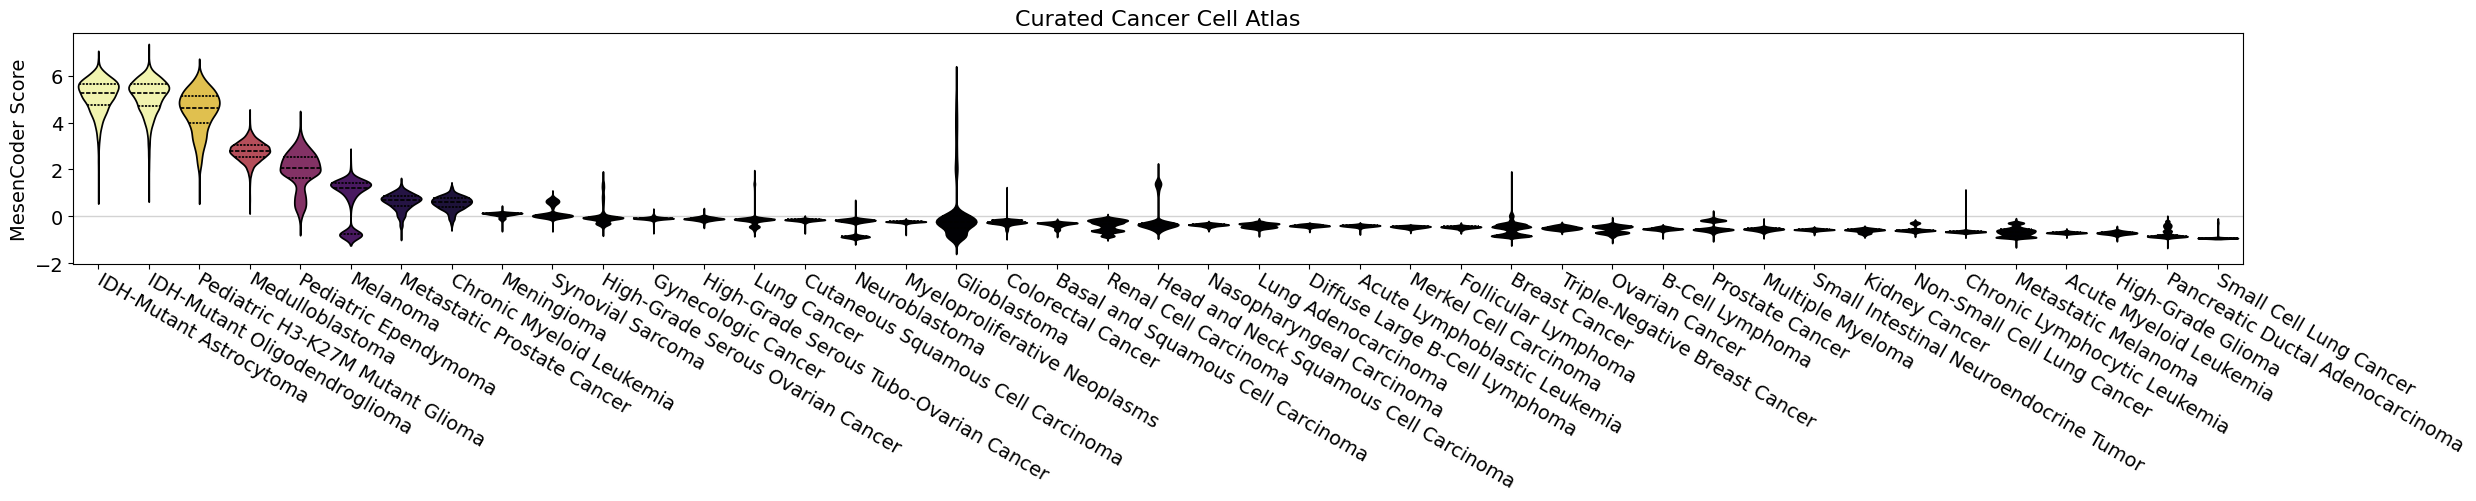

In [26]:
# curated cancer cell atlas
fs1, fs2, rot, pad = 14, 16, -30, 6
fig, ax = plt.subplots(1, 1, figsize = (28, 3))
df_plt = adata[adata.obs.celltype == 'Malignant'].obs.copy()
hue = df_plt.groupby('category').latent_u.median()
ix = hue.sort_values(ascending = False).index
norm = Normalize(vmin = 0, vmax = hue.max())
cmap_ = plt.cm.get_cmap(cmap)
get_color = lambda x: mcolors.to_hex(cmap_(norm(x)))
palette = hue.apply(get_color).to_dict()

sns.violinplot(df_plt,
               y = 'latent_u',
               x = 'category',
               hue = 'category',
               order = ix,
               inner = 'quart',
               density_norm = 'width',
               palette = palette,
               ax = ax)
ax.set_ylabel('MesenCoder Score', size = fs1)
ax.set_xlabel('')
ax.set_title('Curated Cancer Cell Atlas', size = fs2)
ax.set_xticklabels(ax.get_xticklabels(),
                   size = fs1, rotation = rot,
                   rotation_mode = 'anchor',
                   ha = 'left', va = 'center')
ax.tick_params('x', pad = pad)
ax.tick_params('y', labelsize = fs1)
ax.axhline(0, c = 'lightgray', lw = 1, zorder = 0)
fn = os.path.join(pth_out, 'processed', 'malignant.pdf')
plt.savefig(fn, bbox_inches = 'tight')